In [40]:
import pandas as pd
import numpy as np
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans

In [41]:
data = pd.read_csv('datasets/reviews_3k.csv')
data.head()

,Review,Sentiment
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [42]:
# Preprocessing

## Drop missing value
data = data.dropna(axis = 0, how ='any')

In [43]:
from spacy.lang.en.stop_words import STOP_WORDS
import string

# Lemmatization
def lemmetization(doc):
    words = []
    for word in doc:
        if word.lemma_ != "-PRON-":
            temp = word.lemma_.lower().strip()
        else:
            temp = word.lower_

        words.append(temp)

    return words

# Remove punctuation and stopwords
def punc_removal(doc):
    words = []
    for word in doc:
        if word not in list(STOP_WORDS) and word not in string.punctuation:
            words.append(word)
    
    return words

save_words = []
def text_cleaning_english(text,mynlp):

    doc = mynlp(text)
    # lemmetization
    words = lemmetization(doc)
    # remove punctuation
    words = punc_removal(words)

    # save all words in the data file
    for word in words:
        save_words.append(word)

    # traverse in the string     
    complete_sentence = ' '.join([str(word) for word in words])

    return complete_sentence

def most_used_words():
    common_words = Counter(save_words).most_common(5)
    return common_words


In [44]:
nlp = spacy.load("en_core_web_sm")
text_cleaning = lambda x: text_cleaning_english(x,mynlp=nlp)
print(text_cleaning)
data['cleaned_Review'] = pd.DataFrame(data['Review'].apply(text_cleaning))
print(data['cleaned_Review'].head())

common_words = most_used_words()
for key, value in common_words:
    print(f"{key}: {value}")

0          absolutely wonderful silky sexy comfortable
1    love dress sooo pretty happen find store glad ...
2    high hope dress want work initially order peti...
3    love love love jumpsuit fun flirty fabulous ti...
4    shirt flattering adjustable tie perfect length...
Name: cleaned_Review, dtype: object
dress: 1480
fit: 1424
size: 1359
love: 1348
wear: 1318


In [45]:
# # pretrained model
# import joblib
# import sklearn

# model = joblib.load('large_pretrained_sentiment_model.pkl')
# data_predict = model.predict(data['cleaned_Review'])
# data['Predicted'] = data_predict
# data.loc[data['Predicted'] == 1, 'Predicted'] = "Positive"
# data.loc[data['Predicted'] == 0, 'Predicted'] = "Negative"
# print(data[['cleaned_Review', 'Predicted']])

In [46]:
# # split train and test data
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(data['cleaned_Review'],data['Sentiment'],test_size=0.2,shuffle=True, random_state=42)
# print(X_train, y_train)

In [47]:
# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_convert = TfidfVectorizer(analyzer=text_cleaning).fit(data['Review'])
X_transformed=tfidf_convert.transform(data['Review'])

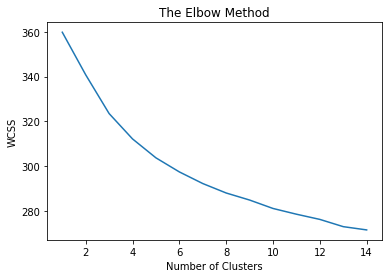

In [48]:
# Elbow method

wcss=[]
for i in range(1,15):
    kmeans=KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmeans.fit(X_transformed)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,15),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [55]:
num_cluster = 15

km = KMeans(n_clusters=num_cluster,init='k-means++',n_init=10,max_iter=300,tol=0.0001)
model = km.fit(X_transformed)
clusters = model.labels_
# print(f'Clusters: {clusters}')
data['clusters'] = clusters
data[['Review', 'clusters']]

,Review,clusters
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,2
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,2
...,...,...
2994,"Did not work for me. material was a bit thin, ...",1
2995,Wow! love this skirt! and i totally agree with...,3
2996,I have the moss colored pilcro skirt that is o...,1
2997,The perfect cardigan for transitional seasons!...,4


In [56]:
data['clusters'].value_counts()

0    715
4    680
1    544
2    497
5    389
3    174
Name: clusters, dtype: int64

In [57]:
data[data['clusters'] == 1]

,Review,Sentiment,cleaned_Review,clusters
0,Absolutely wonderful - silky and sexy and comf...,1,absolutely wonderful silky sexy comfortable,1
3,"I love, love, love this jumpsuit. it's fun, fl...",1,love love love jumpsuit fun flirty fabulous ti...,1
30,Beautifully made pants and on trend with the f...,1,beautifully pant trend flare crop cut person love,1
35,Wouldn't have given them a second look but tri...,1,second look try store whim love love,1
42,This poncho is so cute i love the plaid check ...,1,poncho cute love plaid check design color look...,1
...,...,...,...,...
2971,I love it! it's cute and short and shows off m...,1,love cute short leg material thick great quali...,1
2986,On the mannequin this looked adorable. it is m...,0,mannequin look adorable bustline billow like t...,1
2992,First i must say that i bought this zip up hoo...,1,buy zip hoodie material incredibly soft comfor...,1
2994,"Did not work for me. material was a bit thin, ...",0,work material bit thin poor quality tie work c...,1


In [58]:
# Evaluation
from sklearn.metrics import silhouette_samples, silhouette_score

cluster_values = len(set(clusters))- (1 if -1 in clusters else 0)
silhouette_values = silhouette_score(X_transformed, clusters)
print(f'Silhouette Score: {silhouette_values}')

Silhouette Score: 0.0410024255550405


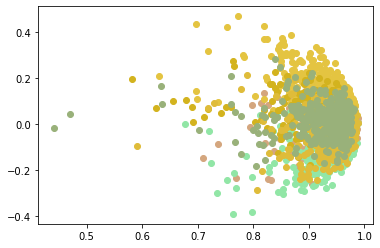

In [59]:
# PCA Data combine with Predicted for graph
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Predicted
data_predicted = model.predict(X_transformed)
pca = TruncatedSVD(n_components=2)
pca.fit(X_transformed)
data_pca = pca.transform(X_transformed)
data_after_pca = pd.DataFrame(data_pca,columns=['Feature-1','Feature-2'])
data_after_pca['Predicted'] = data_predicted

for i in range(num_cluster):
    plt.scatter(data_after_pca['Feature-1'][data_after_pca['Predicted'] == i], 
    data_after_pca['Feature-2'][data_after_pca['Predicted'] == i], c=[np.random.rand(3,)])

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.06592970564969318
For n_clusters = 3 The average silhouette_score is : 0.06975694068754426
For n_clusters = 4 The average silhouette_score is : 0.051810814756705834
For n_clusters = 5 The average silhouette_score is : 0.04663308413069774
For n_clusters = 6 The average silhouette_score is : 0.04078635796819407
For n_clusters = 7 The average silhouette_score is : 0.03746891135510047
For n_clusters = 8 The average silhouette_score is : 0.0372151624849901


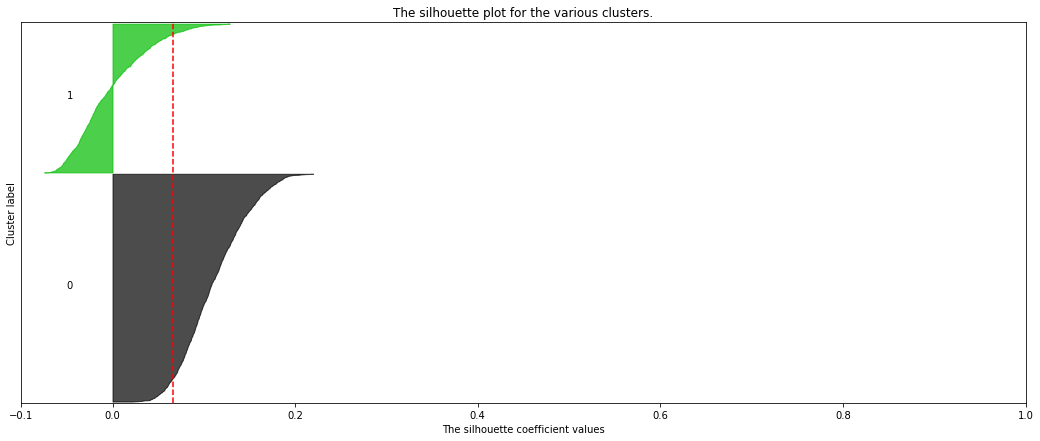

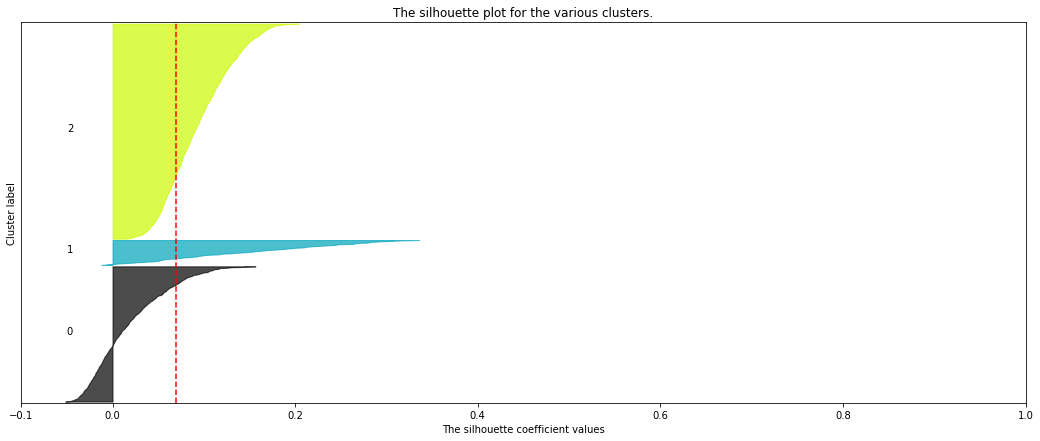

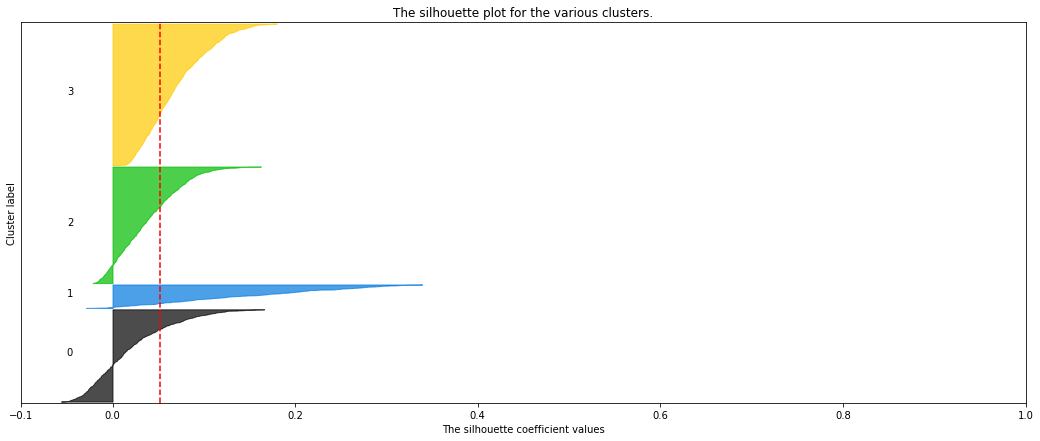

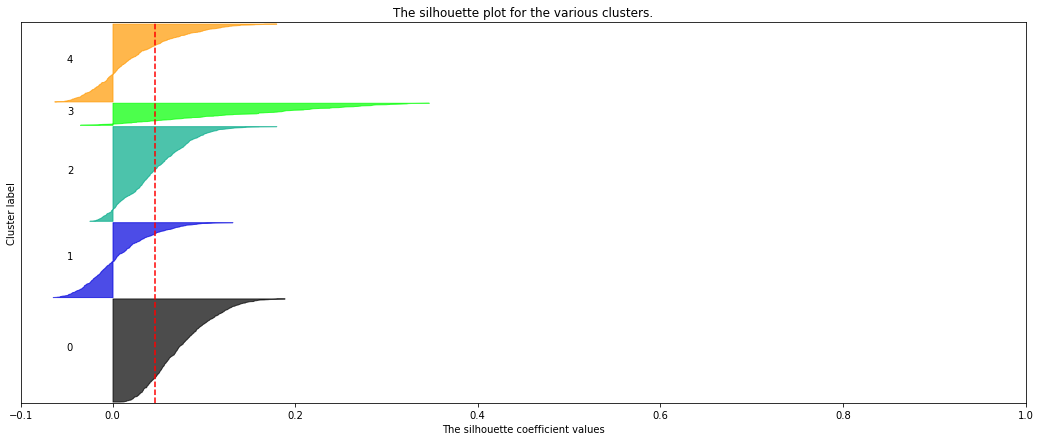

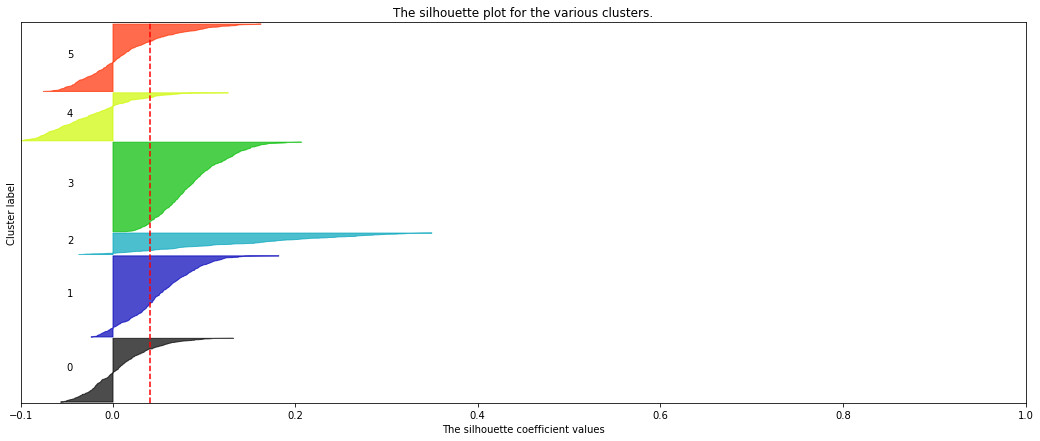

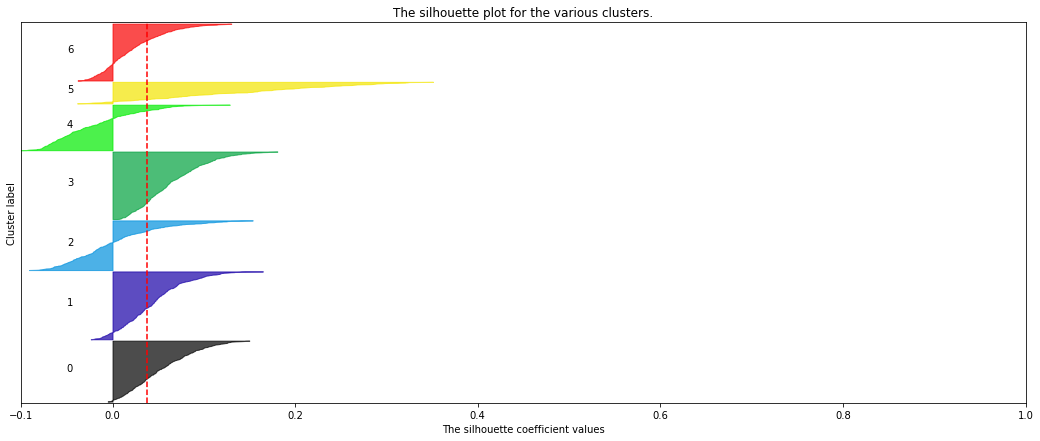

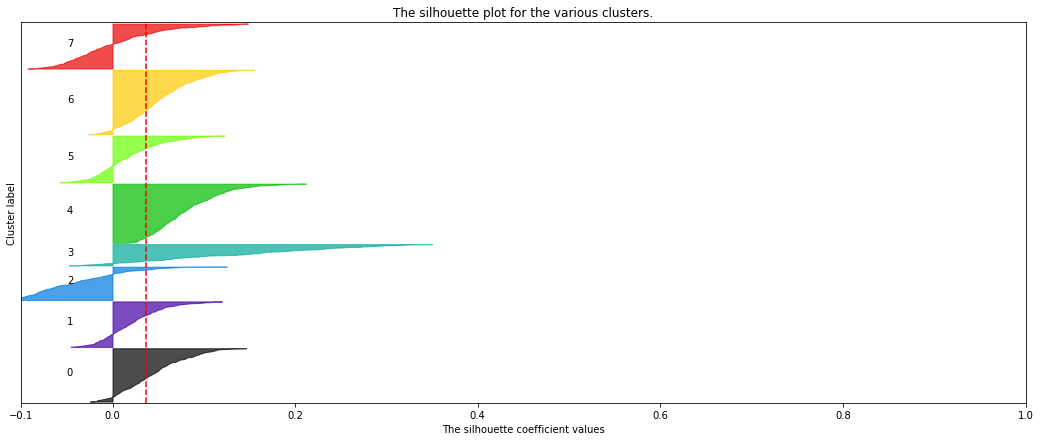

In [54]:
# from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range(2, (num_cluster+1)):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X_transformed.shape[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_transformed)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_transformed, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_transformed, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()